In [149]:
# Data set handling
import pandas as pd

# Numerical computations
import numpy as np

# For plots
import matplotlib.pyplot as plt
import seaborn as sns
# Set theme
sns.set_theme(style="whitegrid")
palette = sns.color_palette("Set2", 8)

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report, confusion_matrix


In [150]:
df = pd.read_csv('f1_dnf.csv')
df.head()

,resultId,raceId,year,round,grid,positionOrder,points,laps,milliseconds,fastestLap,...,circuitRef,circuitId,name_y,location,country,lat,lng,alt,date,target_finish
0,2460,136,2002,13,11,4,3.0,77.0,NaN,\N,...,hungaroring,11,McLaren,Budapest,Hungary,47.5789,19.24860,264,2002-08-18,1
1,11565,483,1981,1,23,21,0.0,16.0,\N,\N,...,long_beach,43,McLaren,California,USA,33.7651,-118.18900,12,1981-03-15,0
2,18661,772,1958,8,0,26,0.0,0.0,\N,\N,...,nurburgring,20,Maserati,Nürburg,Germany,50.3356,6.94750,578,1958-08-03,0
3,25121,1058,2021,8,19,16,0.0,69.0,\N,57,...,red_bull_ring,70,Haas F1 Team,Spielberg,Austria,47.2197,14.76470,678,2021-06-27,0
4,8863,383,1988,12,0,30,0.0,0.0,\N,\N,...,monza,14,Euro Brun,Monza,Italy,45.6156,9.28111,162,1988-09-11,0


# Data Engeneering 

`resultlD` is simply id that doesn't give us any information. `driverRef` is a combined information of the `surname` and `forename`. Same for `constructorRef` and `name_y`, `circutRef` and `name`. So, we'll drop excessive information.

Some columns have a lot of "\N" - substitute them with NAs.

In [151]:
filtered_df = (df
               .drop(columns=['resultId', 'surname', 'forename','name_y','name'])
               .replace('\\N', pd.NA)
    )
filtered_df.head()

,raceId,year,round,grid,positionOrder,points,laps,milliseconds,fastestLap,rank,...,nationality_y,circuitRef,circuitId,location,country,lat,lng,alt,date,target_finish
0,136,2002,13,11,4,3.0,77.0,NaN,<NA>,<NA>,...,British,hungaroring,11,Budapest,Hungary,47.5789,19.24860,264,2002-08-18,1
1,483,1981,1,23,21,0.0,16.0,<NA>,<NA>,<NA>,...,British,long_beach,43,California,USA,33.7651,-118.18900,12,1981-03-15,0
2,772,1958,8,0,26,0.0,0.0,<NA>,<NA>,<NA>,...,Italian,nurburgring,20,Nürburg,Germany,50.3356,6.94750,578,1958-08-03,0
3,1058,2021,8,19,16,0.0,69.0,<NA>,57,16,...,American,red_bull_ring,70,Spielberg,Austria,47.2197,14.76470,678,2021-06-27,0
4,383,1988,12,0,30,0.0,0.0,<NA>,<NA>,<NA>,...,Italian,monza,14,Monza,Italy,45.6156,9.28111,162,1988-09-11,0


In [152]:
# Add some columns and drop unneeded ones
filtered_df['fastestLap_ms'] = (
    pd.to_timedelta('00:' + filtered_df['fastestLapTime'], errors='coerce')
    .dt.total_seconds() * 1000
)
filtered_df.drop(columns=['fastestLapTime'], inplace=True)

filtered_df['driver_age_days'] = (pd.to_datetime(filtered_df['date'], format='%Y-%m-%d', errors='coerce') - 
                                  pd.to_datetime(filtered_df['dob'], format='%Y-%m-%d', errors='coerce')).dt.days
filtered_df.drop(columns=['dob'], inplace=True)

# Keep date columns
filtered_df['date'] = pd.to_datetime(filtered_df['date'], format='%Y-%m-%d', errors='coerce')
filtered_df['race_year'] = filtered_df['date'].dt.year
filtered_df['race_month'] = filtered_df['date'].dt.month
filtered_df['race_day'] = filtered_df['date'].dt.day
filtered_df.drop(columns=['date','year'], inplace=True) # drop original 'year' column because we have 'race_year'
filtered_df

,raceId,round,grid,positionOrder,points,laps,milliseconds,fastestLap,rank,fastestLapSpeed,...,country,lat,lng,alt,target_finish,fastestLap_ms,driver_age_days,race_year,race_month,race_day
0,136,13,11,4,3.0,77.0,NaN,<NA>,<NA>,<NA>,...,Hungary,47.5789,19.24860,264,1,NaN,8341,2002,8,18
1,483,1,23,21,0.0,16.0,<NA>,<NA>,<NA>,<NA>,...,USA,33.7651,-118.18900,12,0,NaN,12734,1981,3,15
2,772,8,0,26,0.0,0.0,<NA>,<NA>,<NA>,<NA>,...,Germany,50.3356,6.94750,578,0,NaN,10372,1958,8,3
3,1058,8,19,16,0.0,69.0,<NA>,57,16,222.052,...,Austria,47.2197,14.76470,678,0,70005.0,8133,2021,6,27
4,383,12,0,30,0.0,0.0,<NA>,<NA>,<NA>,<NA>,...,Italy,45.6156,9.28111,162,0,NaN,9254,1988,9,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,70,18,22,12,0.0,70.0,<NA>,62,11,210.480,...,Brazil,-23.7036,-46.69970,785,0,73700.0,9160,2006,10,22
9996,55,3,16,7,2.0,57.0,5719770,32,6,217.707,...,Australia,-37.8497,144.96800,10,1,87690.0,12367,2006,4,2
9997,957,10,16,17,0.0,49.0,<NA>,43,12,217.248,...,UK,52.0786,-1.01694,153,0,97619.0,8679,2016,7,10
9998,501,4,0,25,0.0,0.0,NaN,<NA>,<NA>,<NA>,...,USA,33.7651,-118.18900,12,0,NaN,9936,1980,3,30


In [153]:
# Rename columns for easier access
filtered_df = filtered_df.rename(columns={
    'milliseconds': 'total_time_ms',
    'nationality_x': 'driver_nationality',
    'nationality_y': 'constructor_nationality',
})
filtered_df

,raceId,round,grid,positionOrder,points,laps,total_time_ms,fastestLap,rank,fastestLapSpeed,...,country,lat,lng,alt,target_finish,fastestLap_ms,driver_age_days,race_year,race_month,race_day
0,136,13,11,4,3.0,77.0,NaN,<NA>,<NA>,<NA>,...,Hungary,47.5789,19.24860,264,1,NaN,8341,2002,8,18
1,483,1,23,21,0.0,16.0,<NA>,<NA>,<NA>,<NA>,...,USA,33.7651,-118.18900,12,0,NaN,12734,1981,3,15
2,772,8,0,26,0.0,0.0,<NA>,<NA>,<NA>,<NA>,...,Germany,50.3356,6.94750,578,0,NaN,10372,1958,8,3
3,1058,8,19,16,0.0,69.0,<NA>,57,16,222.052,...,Austria,47.2197,14.76470,678,0,70005.0,8133,2021,6,27
4,383,12,0,30,0.0,0.0,<NA>,<NA>,<NA>,<NA>,...,Italy,45.6156,9.28111,162,0,NaN,9254,1988,9,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,70,18,22,12,0.0,70.0,<NA>,62,11,210.480,...,Brazil,-23.7036,-46.69970,785,0,73700.0,9160,2006,10,22
9996,55,3,16,7,2.0,57.0,5719770,32,6,217.707,...,Australia,-37.8497,144.96800,10,1,87690.0,12367,2006,4,2
9997,957,10,16,17,0.0,49.0,<NA>,43,12,217.248,...,UK,52.0786,-1.01694,153,0,97619.0,8679,2016,7,10
9998,501,4,0,25,0.0,0.0,NaN,<NA>,<NA>,<NA>,...,USA,33.7651,-118.18900,12,0,NaN,9936,1980,3,30


In [154]:
# Change other columns data types
float_columns = ['total_time_ms', 'fastestLapSpeed']
integer_columns = ['fastestLap', 'rank']
category_columns = ['raceId','driverRef','driver_nationality','constructorRef',
                    'constructor_nationality','circuitRef','location',
                    'country','target_finish']

for col in float_columns:
    filtered_df[col] = pd.to_numeric(filtered_df[col], errors='coerce')
for col in integer_columns:
    filtered_df[col] = pd.to_numeric(filtered_df[col], errors='coerce', downcast='integer')
for col in category_columns:
    filtered_df[col] = filtered_df[col].astype('category')

filtered_df.dtypes

raceId                     category
round                         int64
grid                          int64
positionOrder                 int64
points                      float64
laps                        float64
total_time_ms               float64
fastestLap                  float64
rank                        float64
fastestLapSpeed             float64
driverRef                  category
driver_nationality         category
constructorRef             category
constructor_nationality    category
circuitRef                 category
circuitId                     int64
location                   category
country                    category
lat                         float64
lng                         float64
alt                           int64
target_finish              category
fastestLap_ms               float64
driver_age_days               int64
race_year                     int32
race_month                    int32
race_day                      int32
dtype: object

In [155]:
# Check for missing values
filtered_df.isna().sum()

raceId                        0
round                         0
grid                          0
positionOrder                 0
points                      971
laps                        978
total_time_ms              7393
fastestLap                 6895
rank                       6798
fastestLapSpeed            7191
driverRef                     0
driver_nationality            0
constructorRef                0
constructor_nationality       0
circuitRef                    0
circuitId                     0
location                      0
country                       0
lat                           0
lng                           0
alt                           0
target_finish                 0
fastestLap_ms              6895
driver_age_days               0
race_year                     0
race_month                    0
race_day                      0
dtype: int64

Some columns have more than 6,000 (60%) missing values. It makes sense to simply drop them.
The `point` column also has a lot of missing values, they simply indicate how many points a driver gets for the race. The scale most likely changed a lot over time, so this is not an informative factor - we'll drop it.
Let's have a closer look at the `laps`.

In [156]:
filtered_df['laps'].describe()

count    9022.000000
mean       46.759033
std        29.840206
min         0.000000
25%        23.250000
50%        53.000000
75%        67.000000
max       200.000000
Name: laps, dtype: float64

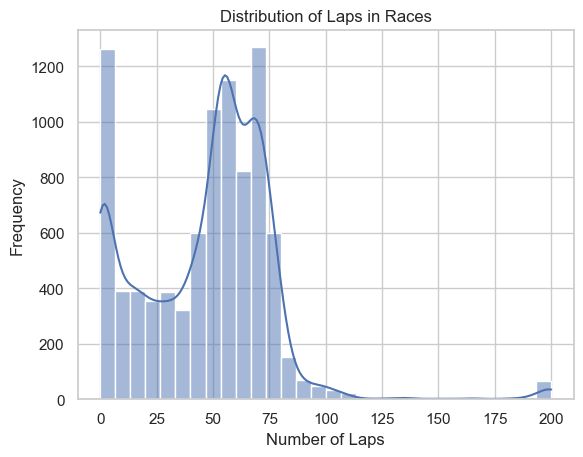

In [157]:
sns.histplot(data=filtered_df, x='laps', bins=30, kde=True)
plt.title('Distribution of Laps in Races')
plt.xlabel('Number of Laps')
plt.ylabel('Frequency')
plt.show()

Possibly there is a very small number of extremely long races (more than 125 laps). For this analysis we'll drop observations where number of laps exceeds 125.

In [158]:
filtered_df.drop(columns=['points', 'total_time_ms','fastestLap', 'rank', 'fastestLapSpeed', 'fastestLap_ms'],inplace=True)
filtered_df = filtered_df[filtered_df['laps'] <= 125]
filtered_df.reset_index(drop=True, inplace=True)
filtered_df.shape

(8927, 21)

This elimination left us 89% of the data which is acceptable.

# EDA

Let's see how driver's age, position order, elevation above the sea level, race year (box-plots), location (frequency plots), correspond to inability to finish the race.

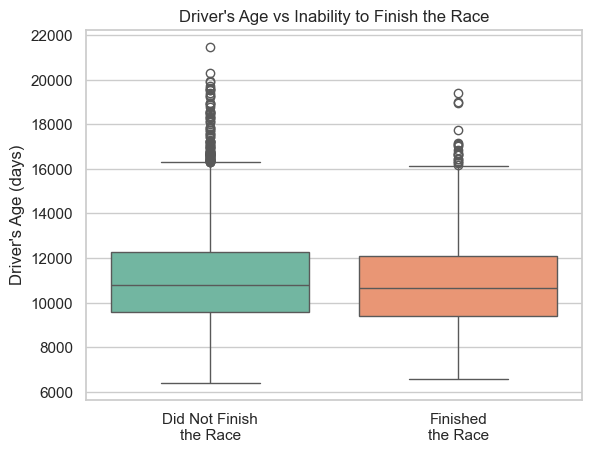

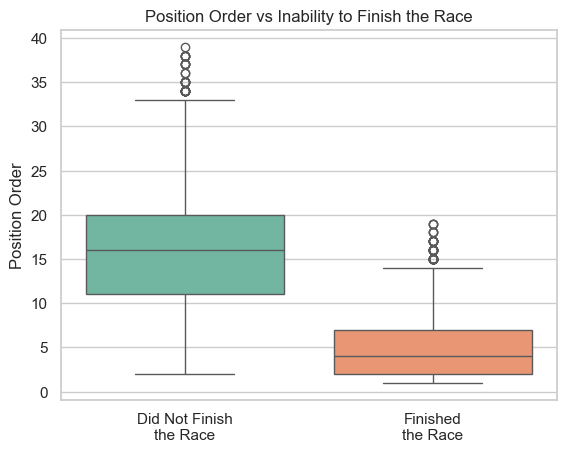

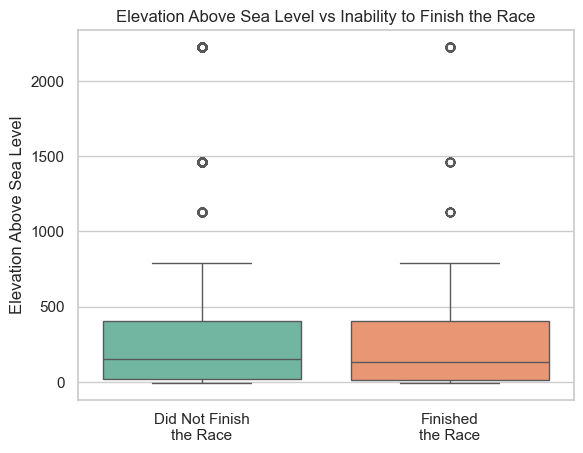

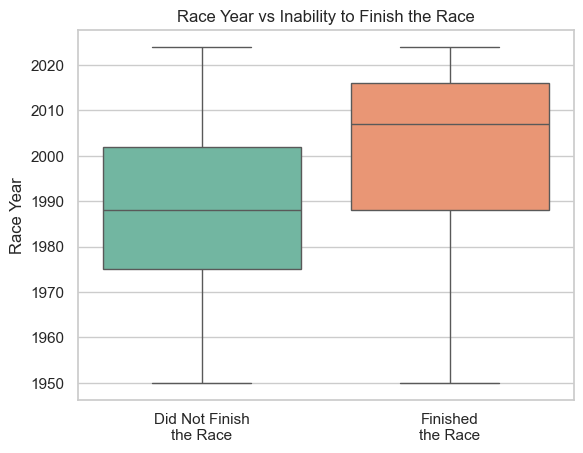

In [159]:
y_cols = ['driver_age_days', 'positionOrder', 'alt', 'race_year']
y_name = ["Driver's Age (days)", 'Position Order', 'Elevation Above Sea Level','Race Year']
plt_title = ["Driver's Age vs Inability to Finish the Race",
             'Position Order vs Inability to Finish the Race',
             'Elevation Above Sea Level vs Inability to Finish the Race',
             'Race Year vs Inability to Finish the Race']

for col, col_name, plot_title in zip(y_cols,y_name, plt_title):
    sns.boxplot(data=filtered_df, 
            x='target_finish', y=col,
            hue='target_finish', 
            order=[0, 1], palette=[palette[0],palette[1]])
    plt.xticks([0, 1], ['Did Not Finish\nthe Race', 'Finished\nthe Race'])
    plt.xlabel('')
    plt.ylabel(col_name)
    plt.title(plot_title)
    plt.legend([],[], frameon=False)
    plt.show()

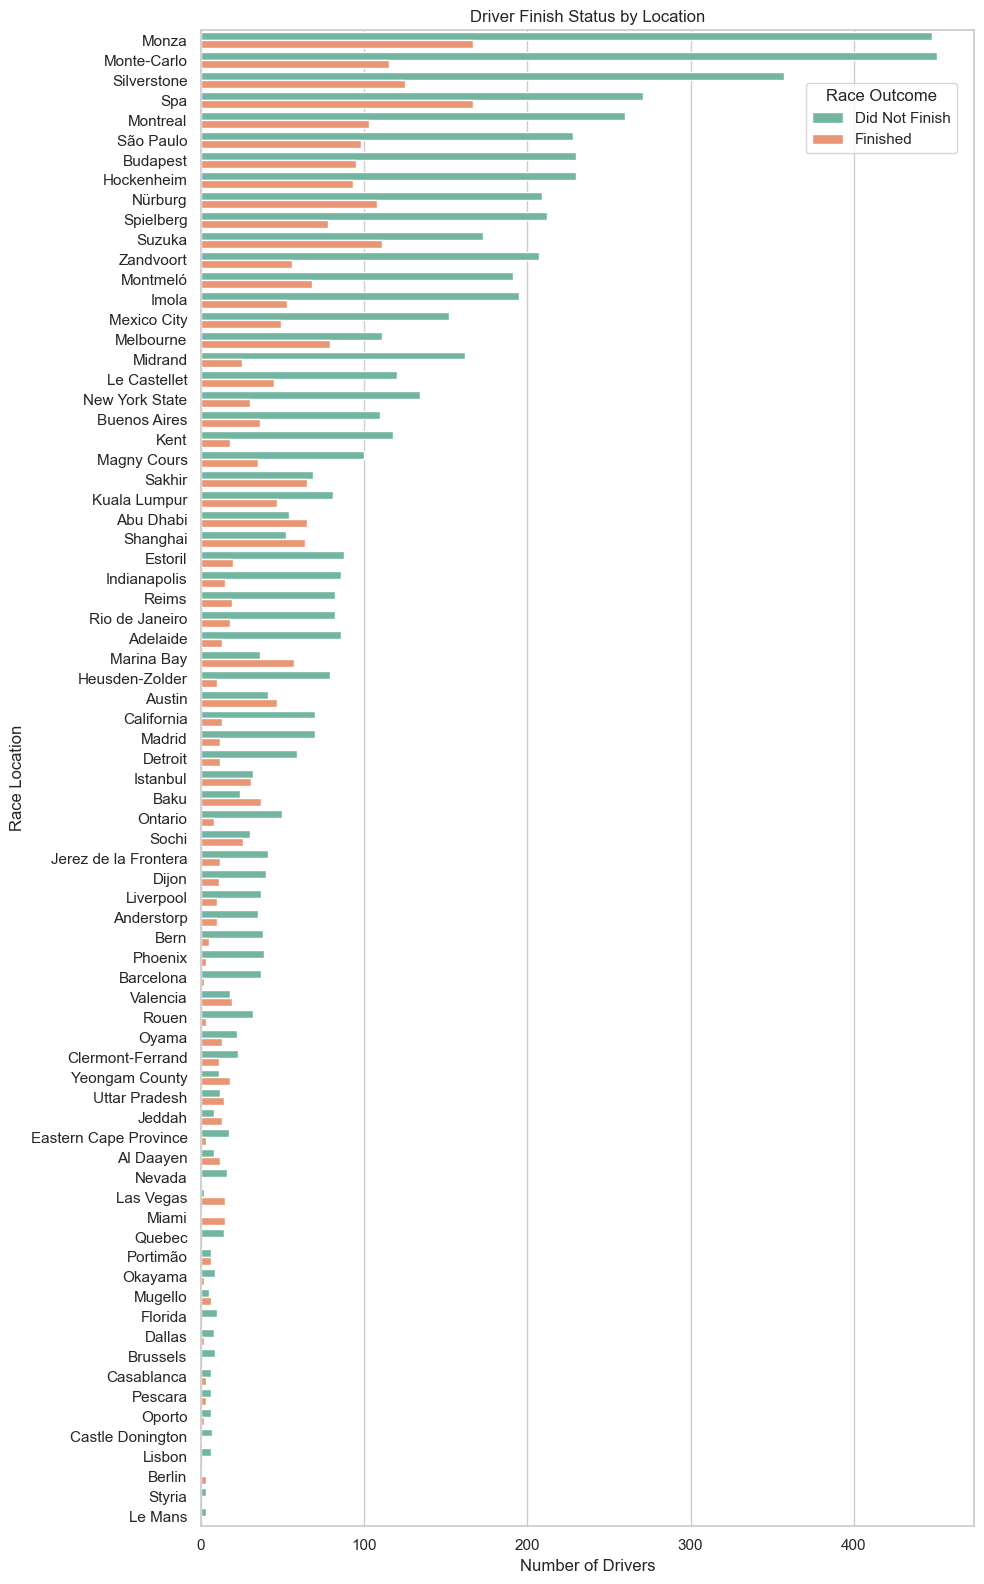

In [160]:
plt.figure(figsize=(10,16)) 
sns.countplot(
    data=filtered_df,
    y='location',
    hue='target_finish',     
    palette=[palette[0], palette[1]],
    order=filtered_df['location'].value_counts().index  # order by frequency
)

plt.ylabel("Race Location")
plt.xlabel("Number of Drivers")
plt.title("Driver Finish Status by Location")
plt.legend(
    title="Race Outcome",
    labels=['Did Not Finish', 'Finished'],
    loc='upper center',         
    bbox_to_anchor=(0.88, 0.97),
    ncol=1
)
plt.tight_layout()
plt.show()

Based on these plots we can see that there are definitely some important factors that can affect whether a driver will or will not finish the race. 

For example, it seems that the starting position can influence that: the closer a driver to the starting line - the more chances that he/she will finish the race. Also, there are some locations that are (probably) very difficult and not everyone can finish the race there. Obviously, races become safer over time, so in recent years more drivers can finish the race. 

# Data Preparation

In [161]:
X = filtered_df.drop(columns=['target_finish'])
X_dummy = pd.get_dummies(X, drop_first=True)
Y = filtered_df['target_finish']

In [162]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_dummy, Y, test_size=0.25, random_state=42)

# Logistic Regression

In [163]:
# Fit the model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, Y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [164]:
# Predictions on the test set
Y_pred_prob = log_model.predict_proba(X_test)[:, 1]

In [165]:
# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
auc_score = roc_auc_score(Y_test, Y_pred_prob)
print("AUC:", auc_score)

AUC: 0.9484182652463061


In [166]:
# Find best threshold (Youden’s J statistic = TPR - FPR)
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_threshold = thresholds[best_idx]
print("Best threshold:", best_threshold)

Best threshold: 0.29049433951816295


In [167]:
Y_pred_opt = (Y_pred_prob >= best_threshold).astype(int)
print("\nAccuracy:", accuracy_score(Y_test, Y_pred_opt))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred_opt))


Accuracy: 0.8691756272401434

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91      1622
           1       0.71      0.88      0.79       610

    accuracy                           0.87      2232
   macro avg       0.83      0.87      0.85      2232
weighted avg       0.88      0.87      0.87      2232



In [168]:
# Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred_opt)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[1405  217]
 [  75  535]]


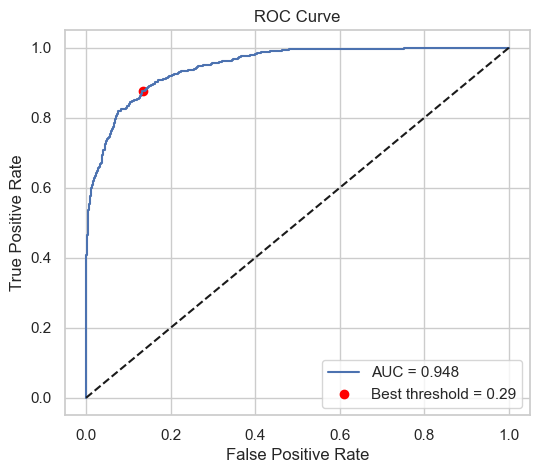

In [169]:
# ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.scatter(fpr[best_idx], tpr[best_idx], color="red", label=f"Best threshold = {best_threshold:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Random Forest

In [170]:
# Fit model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

In [171]:
# Predict probabilities
Y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

In [172]:
# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_prob)
auc_score = roc_auc_score(Y_test, Y_pred_prob)
print("AUC:", auc_score)

AUC: 0.9709860322208971


In [173]:
# Find best threshold (Youden’s J statistic = TPR - FPR)
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_threshold = thresholds[best_idx]
print("Best threshold:", best_threshold)

Best threshold: 0.4


In [174]:
Y_pred_opt = (Y_pred_prob >= best_threshold).astype(int)
print("\nAccuracy:", accuracy_score(Y_test, Y_pred_opt))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred_opt))


Accuracy: 0.9130824372759857

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.94      1622
           1       0.80      0.91      0.85       610

    accuracy                           0.91      2232
   macro avg       0.88      0.91      0.89      2232
weighted avg       0.92      0.91      0.91      2232



In [175]:
# Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred_opt)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[1484  138]
 [  56  554]]


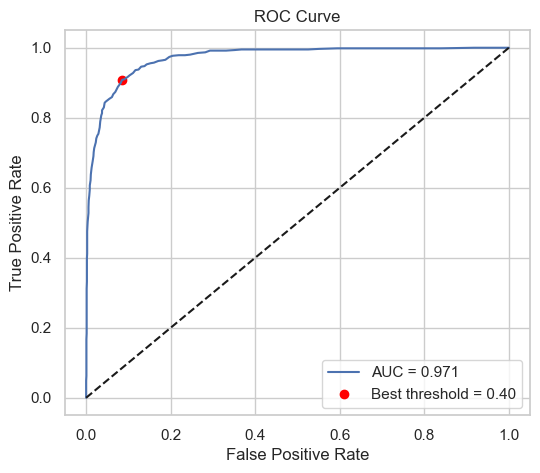

In [176]:
# ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.scatter(fpr[best_idx], tpr[best_idx], color="red", label=f"Best threshold = {best_threshold:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

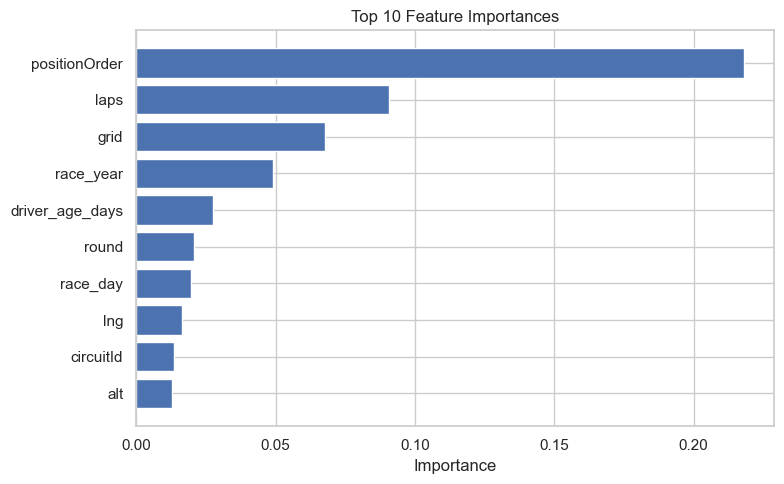

In [180]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1][:10]

# Reverse for plotting so the most important is on top
top_features = importances[indices][::-1]
top_labels = X_test.columns[indices][::-1]

# Plot horizontal bar chart
plt.figure(figsize=(8, 5))
plt.barh(range(10), top_features, align="center")
plt.yticks(range(10), top_labels)
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()

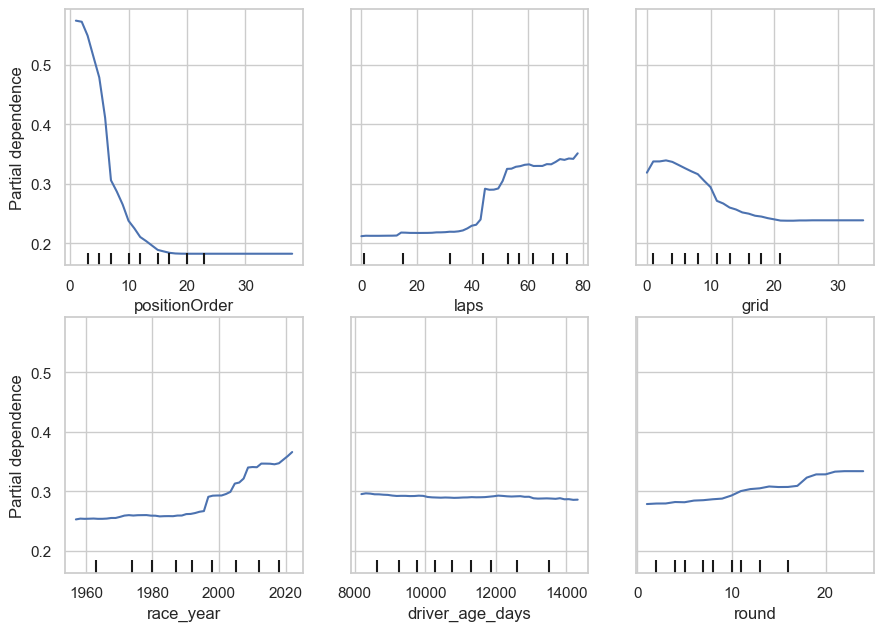

In [ ]:
# Partial Dependence Plots for Top-6 features
features = ['positionOrder', 'laps', 'grid', 'race_year', 'driver_age_days', 'round']

fig, ax = plt.subplots(figsize=(9, 6))
PartialDependenceDisplay.from_estimator(
    rf_model, 
    X_train, 
    features, 
    grid_resolution=50,
    ax=ax,
    n_jobs=6
)
plt.tight_layout()
plt.subplots_adjust(top=1.05)
plt.show()

An interesting observation here: the association between `positionOrder` and `grid` with the target variable - it's negative! Perhaps, the explanation for this that a lot of accidents happen at the start, so the cars that are in the top positions suffer the most, while those that start from behind have time and space to dodge the accident.

Another surprising observation for me that the correlation between `round` and the target variable is positive. Probably, it is due to the fact that drivers gain experience over the race year which reduces the probability of an accident.

Finally, the probability of finishing the race started growing drastically after 1995. One can hypothesize that it is related to rules changes, safety precautions, etc.

# Boosting